In [1]:
import sys, os, pickle
import logging
import torch
import torch.nn as nn
import torch.optim as optim
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from training import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(N_in=[2, 5, 10, 20, 30, 40, 50, 60, 70, 100],
                                 num_epochs=[3000, 5000, 10000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Create training data --- ###

#total time
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
time_steps = len(time_vector)

#amount of training data
N_in = params['N_in']
#N_in = 1000
#N_train = N_in
N_train_min = 200

#Kernel parameters
length_scale = 2
variance = 1
def rbf_kernel(t, length_scale=1.0, variance=1.0):
    return variance * np.exp(-0.5 * (t / length_scale) ** 2)
kernel_func = lambda t: rbf_kernel(t, length_scale=length_scale, variance=variance)
T_long = 400
C_true = kernel_func(torch.arange(0, T_long, dt)).to(0)
C_true = torch.cat([C_true, torch.tensor([C_true[-1]]).to(0), torch.flip(C_true[1:], dims=(0,)).to(0)])

#sample GPs
torch.manual_seed(0)
gp_sample = sample_gp(C_true, N_samples=N_in, ft_cutoff=None)
gp_sample = extract_zero_crossing_samples(gp_sample, T_short=T, dt=dt)
training_data = create_training_data(gp_sample, N_in, random=False)
if N_in < N_train_min:
    training_data = (N_train_min // N_in) * training_data

In [4]:
### --- Create network --- ###

torch.manual_seed(i_seed)
N = 50
# Initialize model, loss, optimizer
#if params['pulse_duration'] == 'None':
#    pd = None
#else:
#    pd = params['pulse_duration']
pd = 20
model = RNNModel(N, N_in, init_scale=1, dt=dt, W_scale=0, W_in_scale=1, W_out_scale=0.1,
                 trainable_input=False, trainable_output=False, pulse_duration=pd).to(0)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
### --- Train network --- ###

num_epochs = params['num_epochs']
#num_epochs = 2
batch_size = 50
recycle = False

# Assuming `training_data` is a list of tuples (GP_sample, one_hot_input)
# where GP_sample is of shape (time_steps, 1) and one_hot_input is of shape (N_in,)
if not prototype:
    with open('/home/om2382/low-rank-dims/logs/train_log.log', 'w') as f:
        f.write(f'New file')
for epoch in range(num_epochs):
    idx = random_derangement(len(training_data))
    training_data_ = [training_data[i] for i in idx]
    for i in range(0, len(training_data), batch_size):
        batch_data = training_data_[i:i + batch_size]
        
        # Prepare batch inputs and targets
        batch_inputs = torch.stack([data[1] for data in batch_data]).to(0)  # Shape: (batch_size, N_in)
        batch_targets = torch.stack([data[0] for data in batch_data]).to(0)  # Shape: (batch_size, time_steps, 1)
        
        optimizer.zero_grad()
        
        # Forward pass
        if i > 0 and recycle:
            prev_h = model.hidden_states[-1].detach()
        else:
            prev_h = None
        outputs = model(batch_inputs, time_steps, prev_h=prev_h)
        
        # Compute loss
        loss = criterion(outputs, batch_targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if not prototype:
        with open('/home/om2382/low-rank-dims/logs/train_log.log', 'a') as f:
            f.write(f'Job {i_job} Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}\n')
    else:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    #logging.info(f'Job {i_job} Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/2, Loss: 0.8122960329055786
Epoch 2/2, Loss: 0.8091002702713013


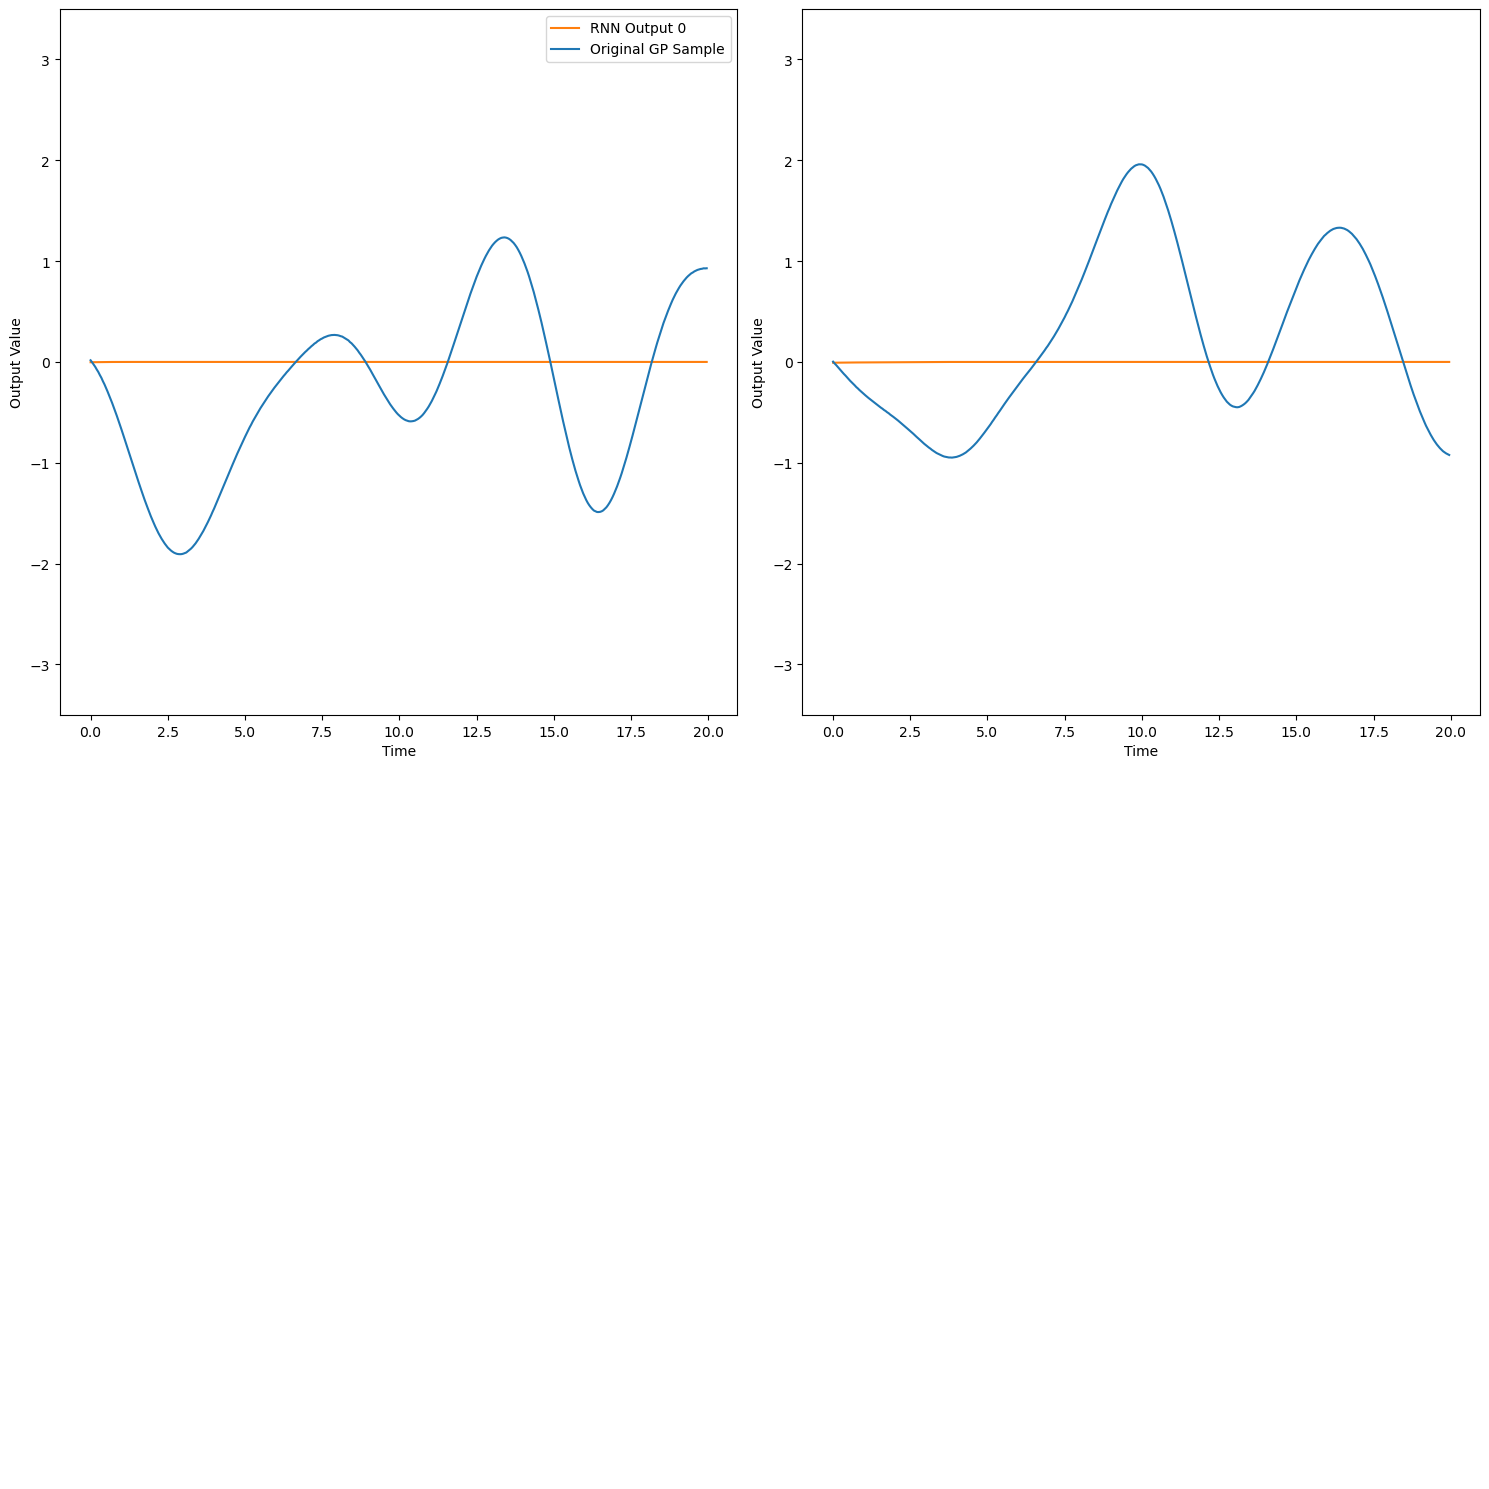

In [6]:
if prototype:
    example_idx = 31  # Choose an index of a GP sample
    example_GP_sample = training_data[example_idx][0]  # Get the GP sample tensor
    example_one_hot_input = training_data[example_idx][1]  # Get the one-hot input tensor

    # Visualize the RNN's performance
    #visualize_rnn_performance(model, example_GP_sample, example_one_hot_input, time_vector=time_vector)
    performances = evaluate_rnn_performance(model, gp_sample,
                                        torch.eye(len(gp_sample)).to(0),
                                        time_vector=time_vector)
    visualize_rnn_performance_multiple_samples(model, gp_sample[:25],
                                           torch.eye(len(gp_sample))[:25].to(0), time_vector=time_vector)

In [ ]:
def sample_network_activity(model, gp_samples, time_vector,
                            dt_save=1, n_test_epochs=5, test_batch_size=10, recycle=False):
    all_epochs_states = []
    time_steps = len(time_vector)
    N_in = gp_samples.shape[0]
    training_data = create_training_data(gp_samples, N_in, random=False)
    indices = []
    for i_epoch in range(n_test_epochs):
        idx = random_derangement(len(training_data))
        training_data_ = [training_data[i] for i in idx]
        all_hidden_states = []
        for i in range(0, len(training_data), test_batch_size):
            batch_data = training_data_[i:i + test_batch_size]

            # Prepare batch inputs and targets
            batch_inputs = torch.stack([data[1] for data in batch_data]).to(0)  # Shape: (batch_size, N_in)
            batch_targets = torch.stack([data[0] for data in batch_data]).to(0)  # Shape: (batch_size, time_steps, 1)

            model.to(0)
            model.eval()

            # Forward pass
            if i > 0 and recycle:
                prev_h = model.hidden_states[-1].detach()
            else:
                prev_h = None
            with torch.no_grad():
                outputs = model(batch_inputs, time_steps, prev_h=prev_h)
            hidden_states = model.get_hidden_states(dt_save=dt_save)  # Shape: (time_steps * batch_size, n_hidden)
            all_hidden_states.append(hidden_states)
        indices.append(idx)
        all_hidden_states = torch.cat(all_hidden_states, dim=1)
        all_epochs_states.append(all_hidden_states)
    all_epochs_states = torch.stack(all_epochs_states)
    all_epochs_states_np = all_epochs_states.cpu().detach().numpy()
    all_epochs_states_np = np.swapaxes(all_epochs_states_np, 1, 2)
    I = np.array(indices)
    Y = np.zeros((n_test_epochs, N_in, time_steps//int(dt_save/dt), N))
    for i in range(n_test_epochs):
        Y[i,:,:,:] = all_epochs_states_np[i,np.argsort(I[i]),:,:]
        
    return Y

In [ ]:
# Y = sample_network_activity(model, gp_sample, time_vector)
# X = np.vstack(np.vstack(Y))
# Cij = np.einsum('ti, tj -> ij', X, X)/(X.shape[0] - 1)
# eigs, v = np.linalg.eig(Cij)
# spec = np.array(sorted(np.abs(eigs))[::-1])
# processed_data = spec

In [ ]:
# Y = np.vstack(X)
# Cij = np.einsum('ti, tj -> ij', Y, Y)/(Y.shape[0] - 1)
# eigs, v = np.linalg.eig(Cij)
# spec = np.array(sorted(np.abs(eigs))[::-1])
# processed_data = np.zeros(N)
# processed_data[:N] = spec
#processed_data = np.zeros(5)

In [ ]:
performances = evaluate_rnn_performance(model, gp_sample,
                                    torch.eye(len(gp_sample)).to(0),
                                    time_vector=time_vector)
processed_data = np.mean(performances)

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))
    model_save_path = os.path.join(save_dir, 'model_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
    state_dict = model.state_dict()
    state_dict['gp_samples'] = gp_sample
    torch.save(state_dict, model_save_path)
except KeyError:
    pass

In [12]:
###Truncate file above
file_name = 'Train_on_GPs'
job_name = 'small_network_4'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Train_on_GPs.ipynb to script
[NbConvertApp] Writing 52492 bytes to Train_on_GPs.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b7a7fac5d50> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b7a7fac5d50> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [13]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/small_network_4/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-

In [21]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
   3940083_[20-90]    lkumar small_ne   om2382 PD       0:00      1 (Resources)
           3940081    lkumar  jupyter   om2382  R      54:14      1 ax14
        3940083_19    lkumar small_ne   om2382  R      43:45      1 ax14
        3940083_18    lkumar small_ne   om2382  R      43:47      1 ax14
        3940083_17    lkumar small_ne   om2382  R      43:49      1 ax16
        3940083_16    lkumar small_ne   om2382  R      43:52      1 ax15
         3940083_1    lkumar small_ne   om2382  R      43:59      1 ax14
         3940083_2    lkumar small_ne   om2382  R      43:59      1 ax14
         3940083_3    lkumar small_ne   om2382  R      43:59      1 ax14
         3940083_4    lkumar small_ne   om2382  R      43:59      1 ax15
         3940083_5    lkumar small_ne   om2382  R      43:59      1 ax15
         3940083_6    lkumar small_ne   om2382  R      43:59      1 ax15
         3940083_7    lkumar sma

In [4]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'small_network_4'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path, results_subdir='misc')

In [5]:
configs_array

{'N_in': [2, 5, 10, 20, 30, 40, 50, 60, 70, 100],
 'num_epochs': [3000, 5000, 10000],
 'i_seed': [0, 1, 2]}

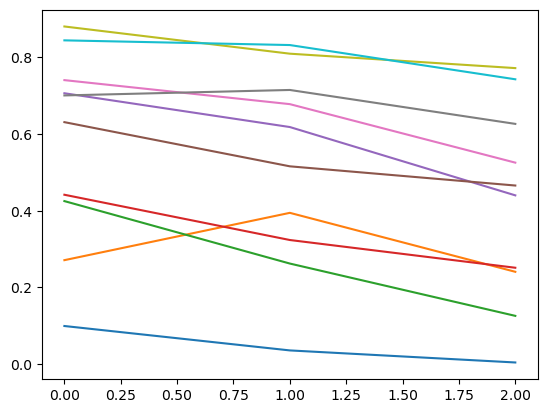

In [7]:
for i in range(10):
    for j in range(1):
        plt.plot(results_array[i,:,j], color='C{}'.format(i))

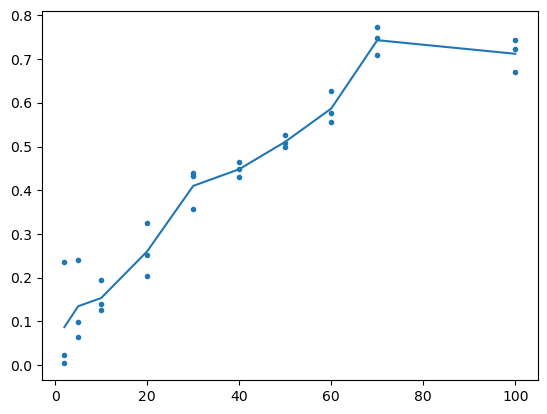

In [10]:
for i in range(3):
    plt.plot(configs_array['N_in'], results_array[:,-1,i], '.', color='C0')
plt.plot(configs_array['N_in'], results_array[:,-1,:].mean(1), color='C0')

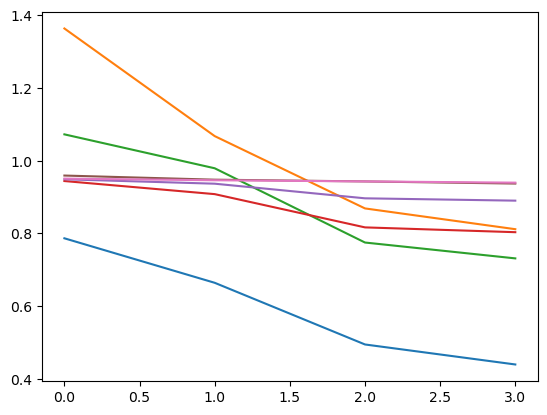

In [5]:
for i in range(7):
    plt.plot(results_array[i,:,:].mean(1))

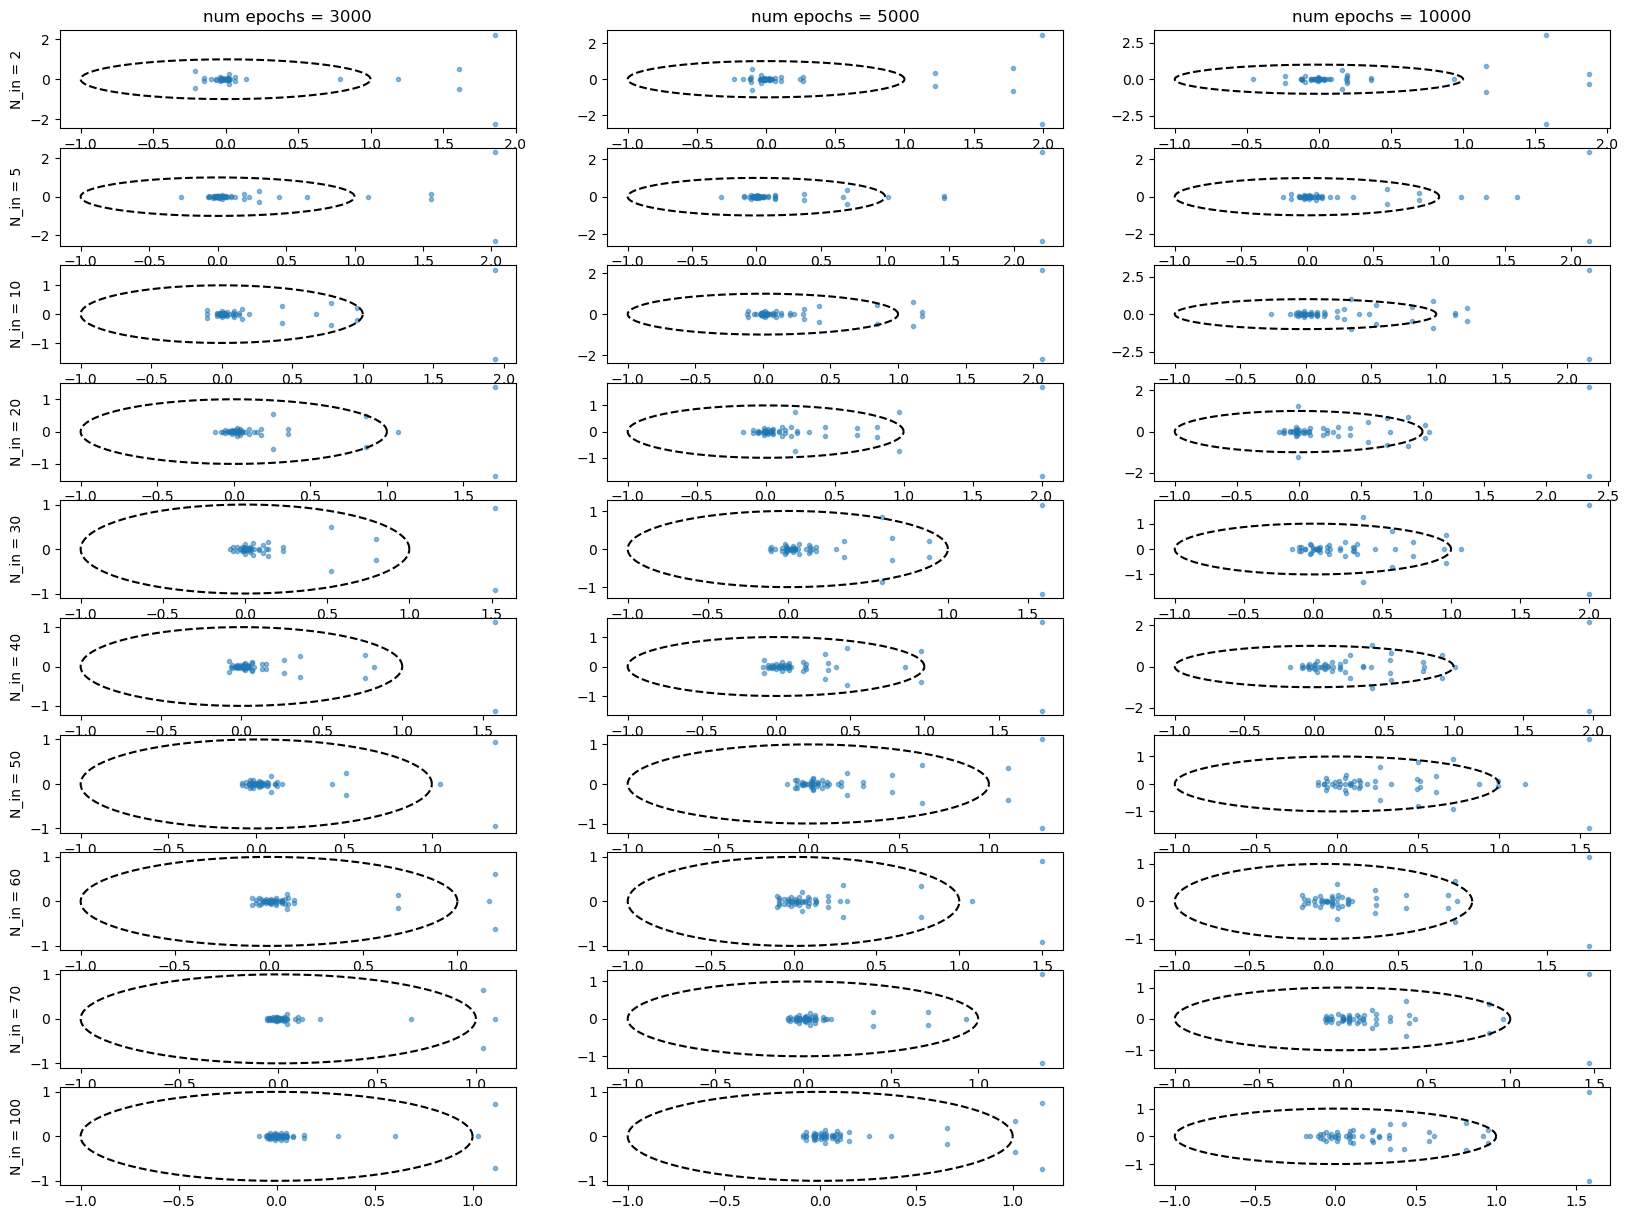

In [16]:
fig, ax = plt.subplots(10, 3, figsize=(20, 15))
from scipy.stats import norm
pulse_duration = 20
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 50
            trainable_input = False
            i_job = reverse_index_config((N_in, num_epochs, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1, dt=0.05, trainable_input=True,
                             pulse_duration=20).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('num epochs = {}'.format(num_epochs))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
configs_array['lr'] = list(reversed(configs_array['lr']))

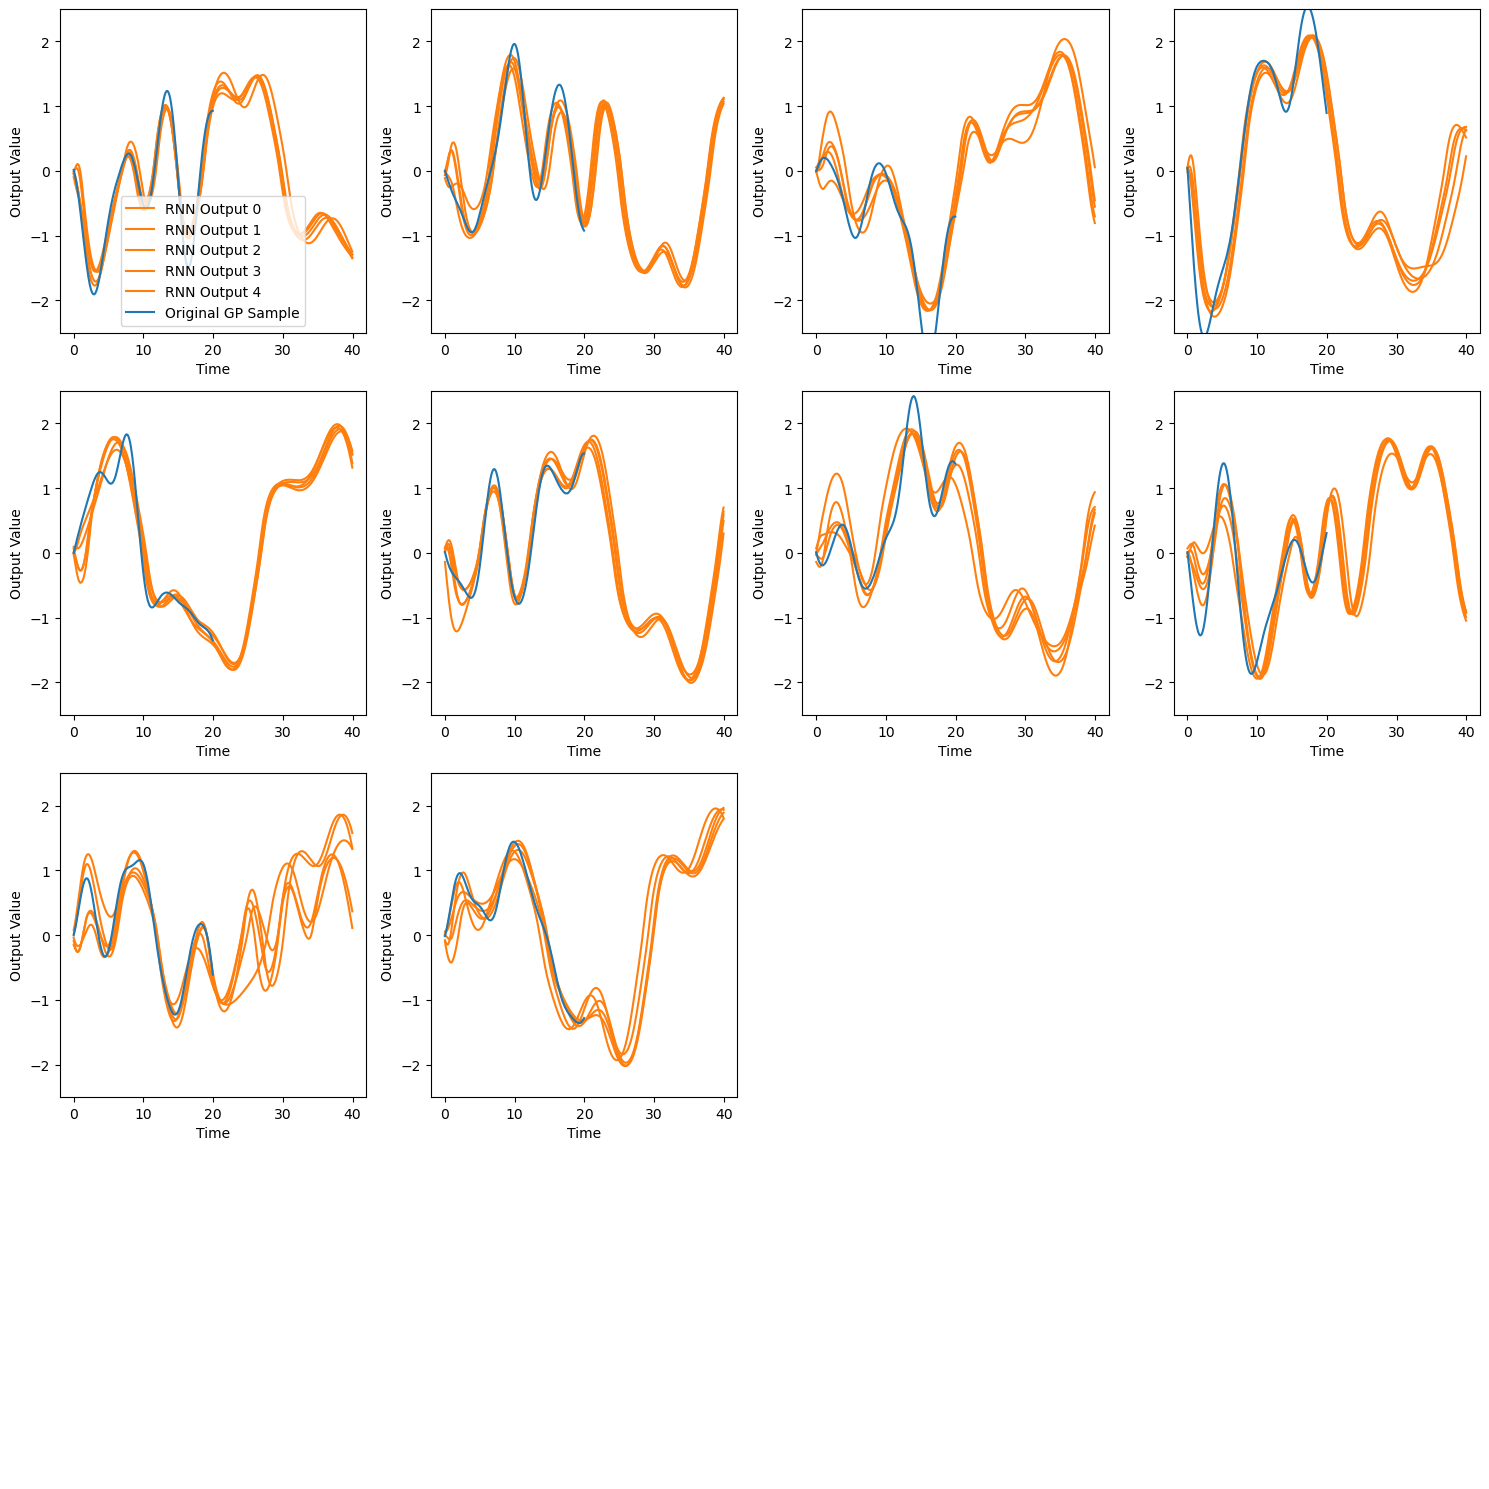

In [14]:
N_in = 10
N = 50
num_epochs = 10000
output_init = 0.1
i_seed = 0
i_job = reverse_index_config((N_in, num_epochs, i_seed), configs_array)
model = RNNModel(N, N_in, init_scale=1, dt=0.05, trainable_input=False, trainable_output=False,
                 W_out_scale=output_init, pulse_duration=20).to(0)
save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
loaded_state_dict = torch.load(model_path)
model.load_state_dict(loaded_state_dict, strict=False)
gp_samples = loaded_state_dict['gp_samples']

# Visualize the RNN's performance
#total time
T = 40
dt = 0.05
time_vector = np.arange(0, T, dt)
visualize_rnn_performance_multiple_samples(model, gp_samples[0:36],
                                           torch.eye(len(gp_samples))[0:36].to(0), time_vector=time_vector,
                                           n_samples=5, ylim=[-2.5, 2.5])

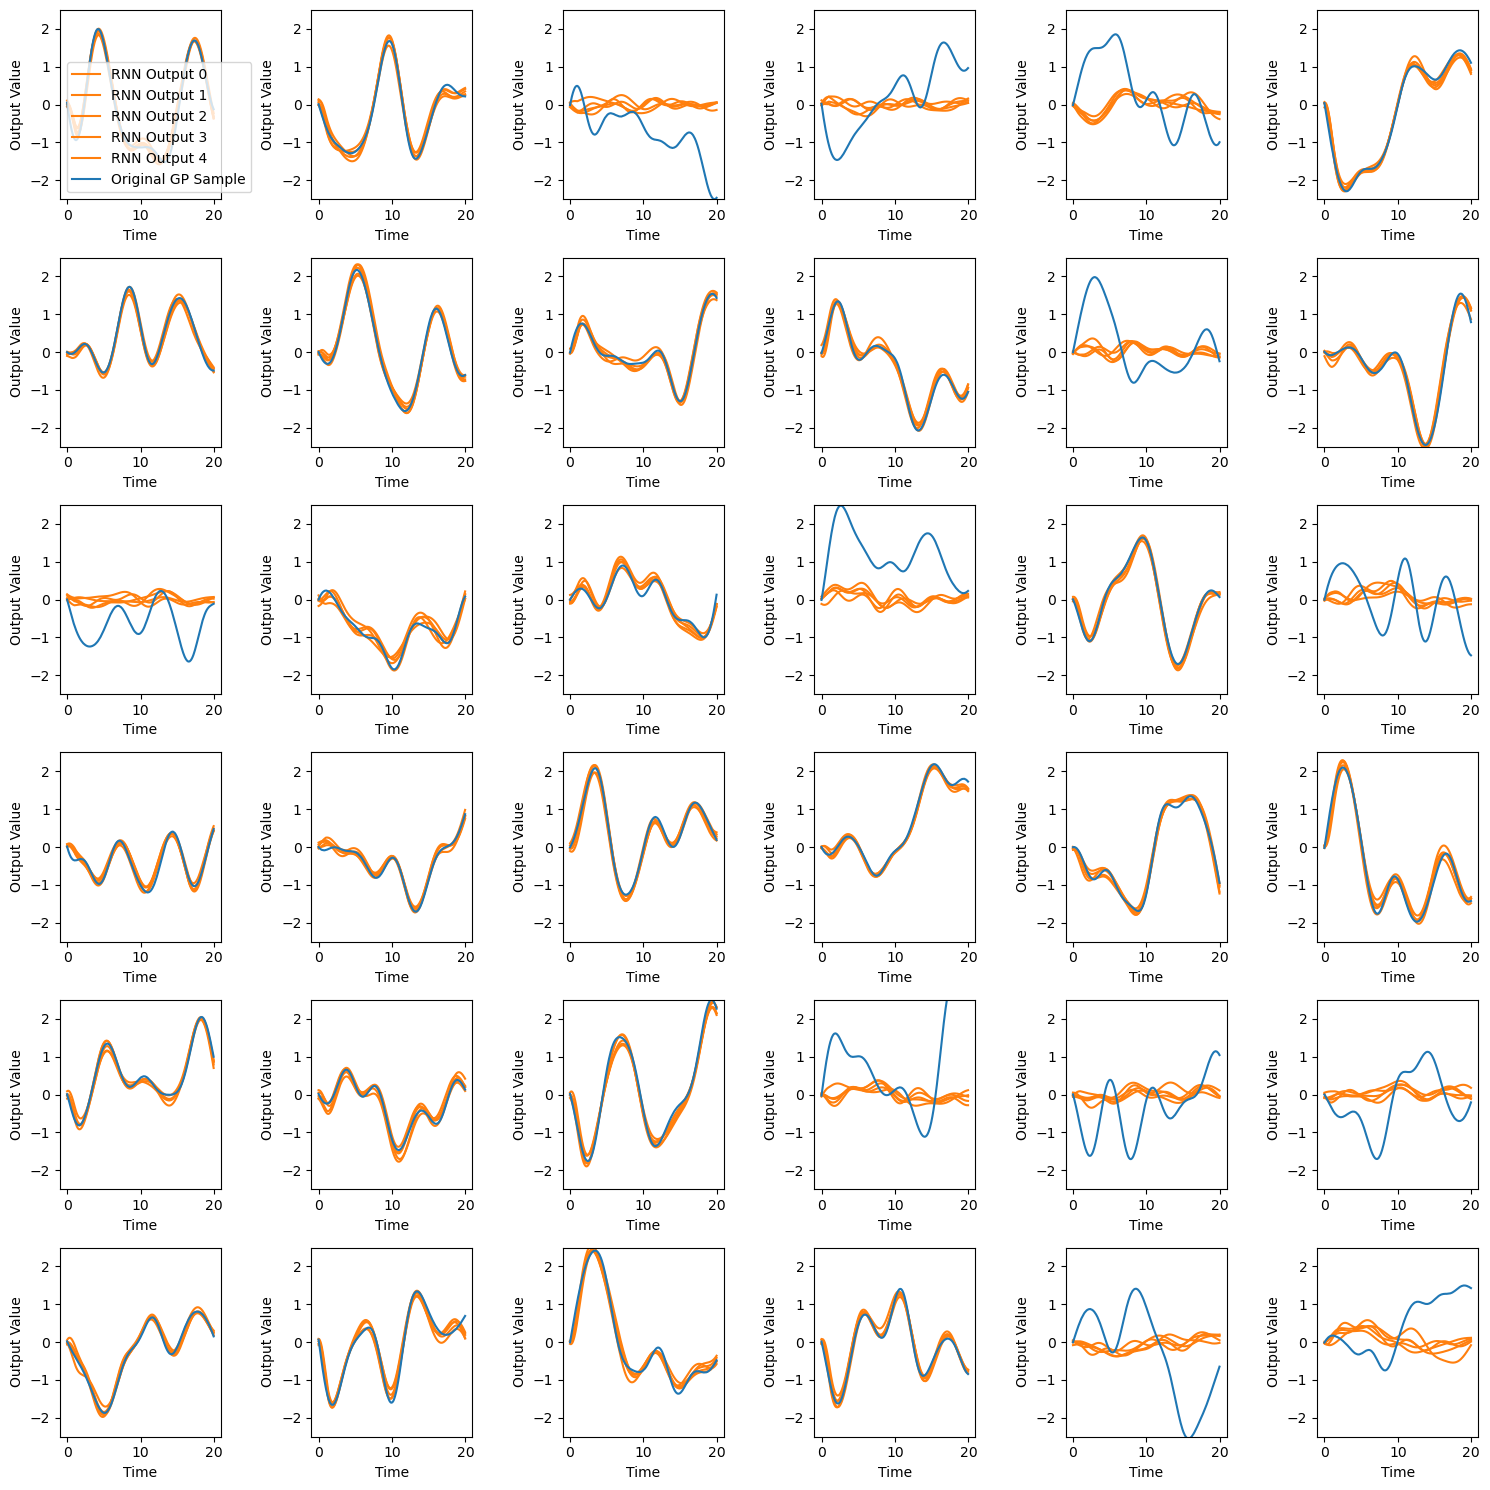

In [13]:
N_in = 100
N = 3000
output_init = 0.1
i_seed = 0
i_job = reverse_index_config((N_in, output_init, i_seed), configs_array)
model = RNNModel(N, N_in, init_scale=1, dt=0.05, trainable_input=False, trainable_output=False,
                 W_out_scale=output_init, pulse_duration=20).to(0)
save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
loaded_state_dict = torch.load(model_path)
model.load_state_dict(loaded_state_dict, strict=False)
gp_samples = loaded_state_dict['gp_samples']

# Visualize the RNN's performance
#total time
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
visualize_rnn_performance_multiple_samples(model, gp_samples[0:36],
                                           torch.eye(len(gp_samples))[0:36].to(0), time_vector=time_vector,
                                           n_samples=5, ylim=[-2.5, 2.5])

In [42]:
def sample_network_activity(model, gp_samples, time_vector,
                            dt_save=1, n_test_epochs=5, test_batch_size=10, recycle=False):
    all_epochs_states = []
    time_steps = len(time_vector)
    N_in = gp_samples.shape[0]
    training_data = create_training_data(gp_samples, N_in, random=False)
    indices = []
    for i_epoch in range(n_test_epochs):
        idx = random_derangement(len(training_data))
        training_data_ = [training_data[i] for i in idx]
        all_hidden_states = []
        for i in range(0, len(training_data), test_batch_size):
            batch_data = training_data_[i:i + test_batch_size]

            # Prepare batch inputs and targets
            batch_inputs = torch.stack([data[1] for data in batch_data]).to(0)  # Shape: (batch_size, N_in)
            batch_targets = torch.stack([data[0] for data in batch_data]).to(0)  # Shape: (batch_size, time_steps, 1)

            model.to(0)
            model.eval()

            # Forward pass
            if i > 0 and recycle:
                prev_h = model.hidden_states[-1].detach()
            else:
                prev_h = None
            with torch.no_grad():
                outputs = model(batch_inputs, time_steps, prev_h=prev_h)
            hidden_states = model.get_hidden_states(dt_save=dt_save)  # Shape: (time_steps * batch_size, n_hidden)
            all_hidden_states.append(hidden_states)
        indices.append(idx)
        all_hidden_states = torch.cat(all_hidden_states, dim=1)
        all_epochs_states.append(all_hidden_states)
    all_epochs_states = torch.stack(all_epochs_states)
    all_epochs_states_np = all_epochs_states.cpu().detach().numpy()
    all_epochs_states_np = np.swapaxes(all_epochs_states_np, 1, 2)
    I = np.array(indices)
    Y = np.zeros((n_test_epochs, N_in, time_steps//int(dt_save/dt), N))
    for i in range(n_test_epochs):
        Y[i,:,:,:] = all_epochs_states_np[i,np.argsort(I[i]),:,:]
        
    return Y

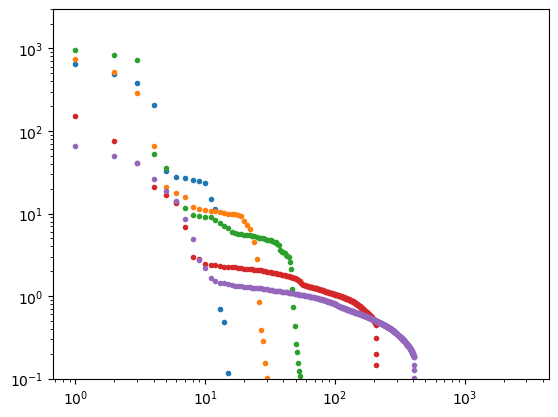

In [49]:
i_seed = 0
output_init = 0.1
for N_in in configs_array['N_in']:
    i_job = reverse_index_config((N_in, output_init, i_seed), configs_array)
    model = RNNModel(N, N_in, init_scale=1, dt=0.05, trainable_input=False, trainable_output=False,
                     W_out_scale=output_init, pulse_duration=20).to(0)
    save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
    model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
    loaded_state_dict = torch.load(model_path)
    model.load_state_dict(loaded_state_dict, strict=False)
    gp_samples = loaded_state_dict['gp_samples']
    Y = sample_network_activity(model, gp_samples, time_vector, n_test_epochs=3)
    X = np.vstack(np.vstack(Y))
    X = X - X.mean(0)[None,:]
    C = np.einsum('ti, tj -> ij', X, X)/(X.shape[0] - 1)

    eigs, vecs = np.linalg.eig(C)
    s = np.array(sorted(np.abs(eigs))[::-1])
    plt.plot(s, '.')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.1, 3000])

In [ ]:
N_in = 1200
N = 3000
pulse_duration = 20
recycle = True
i_seed = 1
i_job = reverse_index_config((N_in, pulse_duration, recycle, i_seed), configs_array)
if pulse_duration == 'None':
    pd = None
else:
    pd = pulse_duration
model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=False,
                 pulse_duration=pd).to(0)
save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
loaded_state_dict = torch.load(model_path)
model.load_state_dict(loaded_state_dict, strict=False)
gp_samples = loaded_state_dict['gp_samples']

# Visualize the RNN's performance
#total time
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
visualize_rnn_performance_multiple_samples(model, gp_samples[0:36],
                                           torch.eye(len(gp_samples))[0:36].to(0), time_vector=time_vector,
                                           n_samples=5, ylim=[-2.5, 2.5])

In [ ]:
fig, ax = plt.subplots(len(configs_array['N_in']), len(configs_array['pulse_duration']))
N_in = 1200
N = 3000
pulse_duration = 20
recycle = True
i_seed = 1
for i, N_in in enumerate(configs_array['N_in']):
    for j, pulse_duration in enumerate(configs_array['pulse_duration']):
        i_job = reverse_index_config((N_in, pulse_duration, recycle, i_seed), configs_array)
        if pulse_duration == 'None':
            pd = None
        else:
            pd = pulse_duration
        model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=False,
                         pulse_duration=pd).to(0)
        save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
        model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
        loaded_state_dict = torch.load(model_path)
        model.load_state_dict(loaded_state_dict, strict=False)
        
        W_ = model.rnn_cell.W.cpu().detach().numpy()
        bins = np.arange(-0.2, 0.2, 0.01)
        eigs, vecs = np.linalg.eig(W_)
        ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
        theta = np.arange(0, 2*np.pi, 0.01)
        ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
        ax[i,j].axis('equal')

In [ ]:
N_recycle = len(configs_array['recycle'])
N_pulse = len(configs_array['pulse_duration'])
N_in = len(configs_array['N_in'])
n_seeds = len(configs_array['i_seed'])
fig, ax = plt.subplots(N_recycle, N_pulse)
N = 3000
avg_performances = np.zeros((N_recycle, N_pulse, N_in, n_seeds))
for i, recycle in enumerate(configs_array['recycle']):
    for j, pulse_duration in enumerate(configs_array['pulse_duration']):
        print(j)
        for k, N_in in enumerate(configs_array['N_in']):
            for i_seed in configs_array['i_seed']:
                i_job = reverse_index_config((N_in, pulse_duration, recycle, i_seed), configs_array)
                if pulse_duration == 'None':
                    pd = None
                else:
                    pd = pulse_duration
                model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=False,
                                 pulse_duration=pd).to(0)
                save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
                model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
                loaded_state_dict = torch.load(model_path)
                model.load_state_dict(loaded_state_dict, strict=False)
                gp_samples = loaded_state_dict['gp_samples']
                performances = evaluate_rnn_performance(model, gp_samples,
                                                        torch.eye(len(gp_samples)).to(0),
                                                        time_vector=time_vector)
                avg_performances[i,j,k,i_seed] = np.mean(performances)

In [ ]:
fig, ax = plt.subplots(N_recycle, N_pulse)
N = 3000
for i, recycle in enumerate(configs_array['recycle']):
    for j, pulse_duration in enumerate(configs_array['pulse_duration']):
        ax[i,j].plot(configs_array['N_in'], avg_performances[i,j,:].mean(-1), '.')
        ax[i,j].set_xticks(configs_array['N_in'])
        ax[i,j].set_ylim([0, 0.05])
        ax[0,j].set_title('pd = {}'.format(pulse_duration))
        ax[i,0].set_ylabel('recycle = {}'.format(recycle))

In [ ]:
all_epochs_states = []
time_steps = len(time_vector)
dt_save = 1
training_data = create_training_data(gp_samples, N_in, random=False)
n_test_epochs = 5
indices = []
for i_epoch in range(n_test_epochs):
    idx = random_derangement(len(training_data))
    test_batch_size = 10
    training_data_ = [training_data[i] for i in idx]
    all_hidden_states = []
    for i in range(0, len(training_data), test_batch_size):
        batch_data = training_data_[i:i + test_batch_size]

        # Prepare batch inputs and targets
        batch_inputs = torch.stack([data[1] for data in batch_data]).to(0)  # Shape: (batch_size, N_in)
        batch_targets = torch.stack([data[0] for data in batch_data]).to(0)  # Shape: (batch_size, time_steps, 1)

        model.to(0)
        model.eval()

        # Forward pass
        if i > 0 and recycle:
            prev_h = model.hidden_states[-1].detach()
        else:
            prev_h = None
        with torch.no_grad():
            outputs = model(batch_inputs, time_steps, prev_h=prev_h)
        hidden_states = model.get_hidden_states(dt_save=dt_save)  # Shape: (time_steps * batch_size, n_hidden)
        all_hidden_states.append(hidden_states)
    indices.append(idx)
    all_hidden_states = torch.cat(all_hidden_states, dim=1)
    all_epochs_states.append(all_hidden_states)
all_epochs_states = torch.stack(all_epochs_states)
all_epochs_states_np = all_epochs_states.cpu().detach().numpy()
all_epochs_states_np = np.swapaxes(all_epochs_states_np, 1, 2)
I = np.array(indices)
Y = np.zeros((n_test_epochs, N_in, time_steps//int(dt_save/dt), N))
for i in range(5):
    Y[i,:,:,:] = all_epochs_states_np[i,np.argsort(I[i]),:,:]

In [ ]:
### --- Verify little variability from run to run --- ###

plt.hist(np.log10(np.std(Y, 0).flatten()), bins=1000)

In [ ]:
#### --- Verify still doing task --- ###
G_hat = np.einsum('bgti, ik -> bgtk', Y, model.W_out.weight.cpu().detach().numpy().T)
for i_task in range(3):
    for i in range(5):
        plt.plot(G_hat[i,i_task,:,0], color='C{}'.format(i_task))
    plt.plot(time_vector, gp_samples.cpu().detach()[i_task], color='C{}'.format(i_task), linestyle='--')

In [ ]:
### --- Overall dimensionality --- ###
U, S, VT = np.linalg.svd(np.vstack(Y[0]))
print(S.sum()**2/(S**2).sum())

In [ ]:
### --- Within task vs. across task dimensionality and power --- ###
n_PCs = 5
Vs = []
for i_task in range(0, 30):
    data = Y[:,i_task,:,:].mean(0)
    data = data - data.mean(0)[None, :]
    U, S, VT = np.linalg.svd(data)
    print(S.sum()**2/(S**2).sum())
    Vs.append(VT.T[:,:n_PCs])

In [ ]:
### --- Within task alignments (across tasks) --- ###
V = np.stack(Vs)
alignments = np.einsum('tik, sil -> tskl', V, V)
A = (alignments**2).sum(-1).sum(-1)/V.shape[-1]
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()

In [ ]:
G = gp_samples.cpu().detach().numpy()
G = G - G.mean(1)[:,None]
G_std = G.std(1)
G_cov = np.einsum('kt, lt -> kl', G, G)/(G.shape[1]-1)/(G_std[:,None]*G_std[None,:])
plt.imshow(G_cov[:30, :30])
plt.colorbar()

In [ ]:
PC_sim = np.einsum('tik, sik-> tsk', V, V)

In [ ]:
### --- Assess how mode correlation goes with GP correlation --- ###
idx = np.triu_indices(30, k=1)
for i_PC in range(3):
    #plt.plot(G_cov[:30,:30].flatten(), PC_sim[:,:,i_PC].flatten(), '.')
    plt.plot(G_cov[idx], PC_sim[:,:,i_PC][idx], '.')
plt.figure()
for i_PC in range(3):
    #plt.plot(G_cov[:30,:30].flatten(), PC_sim[:,:,i_PC].flatten(), '.')
    plt.plot(G_cov[idx]**2, PC_sim[:,:,i_PC][idx]**2, '.')

In [ ]:
idx = np.triu_indices(30, k=1)
R = np.corrcoef(np.vstack([PC_sim[idx].T, G_cov[idx][None,:]]))
plt.plot(R[-1,:-1])
plt.plot(PC_sim[idx].T.std(1))

In [ ]:
### --- With task vs. across task alignments --- ###
Z = Y.mean(0).mean(1)
Z = Z - Z.mean(0)
U, S, VT = np.linalg.svd(Z)
print(S.sum()**2/(S**2).sum())
task_within_alignment = np.einsum('i, ti -> t', VT.T[:,0], V[:,:,0])
plt.plot(task_within_alignment)

In [ ]:
### --- Visualize geometry --- ###
proj_task_mean = Z.dot(VT.T[:,:2])
plt.plot(proj_task_mean[:,0], proj_task_mean[:,1], '.', color='k', alpha=0.05)
for i_task in range(60, 70):
    data = Y[:,i_task,:,:].mean(0)
    data = data - data.mean(0)[None, :]
    #U, S, VT = np.linalg.svd(data)
    print(S.sum()**2/(S**2).sum())
    #Vs.append(VT[:,:n_PCs])
    within_task_activity = data.dot(VT.T[:,:2])
    shifted_proj = proj_task_mean[i_task] + within_task_activity
    plt.plot(shifted_proj[:,0], shifted_proj[:,1], '.', color='C{}'.format(i_task%10))
    plt.plot([proj_task_mean[i_task,0]], [proj_task_mean[i_task,1]], '*', color='C{}'.format(i_task%10))

In [ ]:
### --- Regression of PCs on behavior --- ###
i_task = 10
task_data = Y[0,i_task,:,:]
task_data = task_data - task_data.mean(0)[None, :]
U, S, VT = np.linalg.svd(task_data)
plt.plot(G_hat[:,i_task,:,0].mean(0), color='k')
for i in range(5):
    proj = task_data.dot(VT[i,:])
    plt.plot(proj)
all_proj = task_data.dot(VT.T[:,:n_PCs])

In [ ]:
### --- Correlation of each task PC with behavior --- ###
R_task = np.zeros((50, 15))
for i_task in range(100, 150):
    task_data = Y[0,i_task,:,:]
    task_data = task_data - task_data.mean(0)[None, :]
    U, S, VT = np.linalg.svd(task_data)
    all_proj = task_data.dot(VT.T[:,:15])
    R = np.corrcoef(np.vstack([all_proj.T, G_hat[0,i_task,:,0][None,:]]))
    plt.plot(R[-1,:-1]**2, color='C0', alpha=0.3)
    R_task[i_task - 100, :] = R[-1,:-1]**2
plt.plot(R_task.mean(0))

In [ ]:
plt.plot(np.log10(all_proj.std(0)))

In [ ]:
np.vstack([all_proj.T, G_hat[0,i_task,:,0][None,:]]).shape

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
from scipy.stats import norm
pulse_duration = 20
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 3000
            trainable_input = False
            i_job = reverse_index_config((N_in, num_epochs, pulse_duration, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True,
                             pulse_duration=20).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('num epochs = {}'.format(num_epochs))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
from scipy.stats import norm
pulse_duration = 20
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 3000
            trainable_input = False
            i_job = reverse_index_config((N_in, num_epochs, pulse_duration, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True,
                             pulse_duration=20).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('num epochs = {}'.format(num_epochs))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
U, S, VT = np.linalg.svd(W_)
S.sum()**2/(S**2).sum()/N

In [ ]:
N_in = 500
N = 3000
num_epochs = 1000
pulse_duration = 20
i_seed = 2
i_job = reverse_index_config((N_in, num_epochs, pulse_duration, i_seed), configs_array)
model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=False,
                 pulse_duration=pulse_duration).to(0)
save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
loaded_state_dict = torch.load(model_path)
model.load_state_dict(loaded_state_dict, strict=False)

gp_samples = loaded_state_dict['gp_samples']
training_data = create_training_data(gp_samples, gp_samples.shape[0])
example_idx = 6  # Choose an index of a GP sample
example_GP_sample = training_data[example_idx][0]  # Get the GP sample tensor
example_one_hot_input = training_data[example_idx][1]  # Get the one-hot input tensor

# Visualize the RNN's performance
#total time
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
#visualize_rnn_performance(model, example_GP_sample, example_one_hot_input, time_vector=time_vector)
visualize_rnn_performance_multiple_samples(model, gp_samples[0:36],
                                           torch.eye(len(gp_samples))[0:36].to(0), time_vector=time_vector,
                                           n_samples=5, ylim=[-2.5, 2.5])
#performances = evaluate_rnn_performance(model, gp_samples,
#                                        torch.eye(len(gp_samples)).to(0),
#                                        time_vector=time_vector)

In [ ]:
all_epochs_states = []
time_steps = len(time_vector)
dt_save = 1
training_data = create_training_data(gp_samples, N_in, random=False)
n_test_epochs = 5
indices = []
for i_epoch in range(n_test_epochs):
    idx = random_derangement(len(training_data))
    test_batch_size = 10
    training_data_ = [training_data[i] for i in idx]
    all_hidden_states = []
    for i in range(0, len(training_data), test_batch_size):
        batch_data = training_data_[i:i + test_batch_size]

        # Prepare batch inputs and targets
        batch_inputs = torch.stack([data[1] for data in batch_data]).to(0)  # Shape: (batch_size, N_in)
        batch_targets = torch.stack([data[0] for data in batch_data]).to(0)  # Shape: (batch_size, time_steps, 1)

        model.to(0)
        model.eval()

        # Forward pass
        if i > 0 and False:
            prev_h = model.hidden_states[-1].detach()
        else:
            prev_h = None
        with torch.no_grad():
            outputs = model(batch_inputs, time_steps, prev_h=prev_h)
        hidden_states = model.get_hidden_states(dt_save=dt_save)  # Shape: (time_steps * batch_size, n_hidden)
        all_hidden_states.append(hidden_states)
    indices.append(idx)
    all_hidden_states = torch.cat(all_hidden_states, dim=1)
    all_epochs_states.append(all_hidden_states)
all_epochs_states = torch.stack(all_epochs_states)
all_epochs_states_np = all_epochs_states.cpu().detach().numpy()
all_epochs_states_np = np.swapaxes(all_epochs_states_np, 1, 2)
I = np.array(indices)

In [ ]:
Y = np.zeros((n_test_epochs, N_in, time_steps//int(dt_save/dt), N))
for i in range(5):
    Y[i,:,:,:] = all_epochs_states_np[i,np.argsort(I[i]),:,:]

In [ ]:
from scipy.spatial import distance_matrix
mat = np.vstack(np.swapaxes(np.mean(Y, 2), 0, 1))
dist_matrix = distance_matrix(mat[:,:1000], mat[:,:1000])

In [ ]:
G_hat = np.einsum('bgti, ik -> bgtk', Y, model.W_out.weight.cpu().detach().numpy().T)

In [ ]:
for i_task in range(5,6):
    for i in range(5):
        plt.plot(G_hat[i,i_task,:,0], color='C{}'.format(i_task))
    plt.plot(np.arange(0, 20, 0.05),gp_samples.cpu().detach()[i_task], color='C{}'.format(i_task), linestyle='--')

In [ ]:
plt.imshow(dist_matrix[:100,:100])

In [ ]:
N = 3000
U1 = np.linalg.qr(np.random.normal(0, 1, (N, N)))[0][:,:3]
U2 = np.linalg.qr(np.random.normal(0, 1, (N, N)))[0][:,:3]
np.square(U1.T.dot(U2)).sum()/np.sqrt(3)

In [ ]:
np.square(Vs[0].T.dot(Vs[1])).sum()/np.sqrt(3)

In [ ]:
proj = np.einsum('bgti, ik -> bgtk', Y, VT[:,:2])
for i_task in range(10,20):
    V = Vs[i_task][:,3:5]
    proj = np.einsum('bti, ik -> btk', Y[:,i_task,:,:], V)
    plt.plot(proj[:,:,0].flatten(), proj[:,:,1].flatten(), color='C{}'.format(i_task%10), linewidth=0.2)
    plt.plot(proj[:,0,0].flatten(), proj[:,0,1].flatten(), '*', color='C{}'.format(i_task%10))
    plt.plot(proj[:,-1,0].flatten(), proj[:,-1,1].flatten(), 'x', color='C{}'.format(i_task%10))

In [ ]:
W_o = model.W_out.weight.cpu().detach().numpy().squeeze()

In [ ]:
V_ = np.stack(Vs)

In [ ]:
output_alignments = np.einsum('gik, i -> gk', V_, W_o)

In [ ]:
mean = output_alignments.mean(0)
std = output_alignments.std(0)/np.sqrt(output_alignments.shape[0])
plt.errorbar(x=range(5), y=mean, yerr=std)

In [ ]:
Vs = []
for i_task in range(100, 130):
    data = Y[:,i_task,:,:].mean(0)
    data = data - data.mean(0)[None, :]
    U, S, VT = np.linalg.svd(data)
    print(S.sum()**2/(S**2).sum())
    Vs.append(VT[:,:5])

In [ ]:
U, S, VT = np.linalg.svd(np.vstack(Y[0]))

In [ ]:
print(S.sum()**2/(S**2).sum())

In [ ]:
S[0]

In [ ]:
U, S, VT = np.linalg.svd(Y.reshape((-1, 3000)))

In [ ]:
print(S.sum()**2/(S**2).sum())

In [ ]:
S[0]

In [ ]:
U, S, VT = np.linalg.svd(Y.mean(0).mean(1))

In [ ]:
print(S.sum()**2/(S**2).sum())

In [ ]:
S[0]

In [ ]:
Vs = []
for i_task in range(500):
    data = np.vstack(Y[:,i_task,:,:])
    data = data - data.mean(0)[None, :]
    U, S, VT = np.linalg.svd(data)
    print(S.sum()**2/(S**2).sum())
    Vs.append(VT[:,:5])

In [ ]:
len(Vs)

In [ ]:
V = np.stack(Vs)

In [ ]:
V.shape

In [ ]:
task_within_alignment = np.einsum('i, tik -> tk', VT[:,1], V)

In [ ]:
plt.plot(np.square(task_within_alignment).sum(1)/np.sqrt(5))

In [ ]:
alignments = np.einsum('tik, sil -> tskl', V, V) / np.sqrt(V.shape[-1])

In [ ]:
A = (alignments**2).sum(-1).sum(-1)
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()

In [ ]:
U, S, VT = np.linalg.svd(Y.mean(0).mean(1))

In [ ]:
Z.shape

In [ ]:
Z = Y.mean(0).mean(1)
Z = Z - Z.mean(0)
U, S, VT = np.linalg.svd(Z)

In [ ]:
plt.plot(S, '.')
S.sum()**2/(S**2).sum()

In [ ]:
[VT[:,0].dot(V[i,:,:]) for i in range(30)]

In [ ]:
V.shape

In [ ]:
G = gp_samples.cpu().detach().numpy()
G = G - G.mean(0)[None,:]
G_cov = np.einsum('kt, lt -> kl', G, G)/(G.shape[1]-1)/(np.sqrt(np.square(G).mean(1)[None,:] * np.square(G).mean(1)[:,None]))
plt.imshow(G_cov[:30, :30])
plt.colorbar()

In [ ]:
plt.plot(G_cov[:30,:30].flatten(), A.flatten(), '.')

In [ ]:
from scipy.spatial import distance_matrix
Y = np.vstack(X)
dist_matrix = distance_matrix(Y[::5,:1000], Y[::5,:1000])

In [ ]:
i, j = np.triu_indices(dist_matrix.shape[0])
D = dist_matrix[i, j]
plt.hist(D, bins=1000)
plt.yscale('log')
#plt.xscale('log')

In [ ]:
plt.imshow(dist_matrix[:100, :100])
plt.colorbar()

In [ ]:
Y = np.vstack(X)
Y = Y - Y.mean(0)[None,:]
Y = Y[:, :]

In [ ]:
Y.shape

In [ ]:
PR_T = [0, 0]
for t in range(2, 1000):
    #np.cumsum(Y**2, axis=0).sum()/np.cumsum((Y[:,None,:]*Y[:,:,None]),axis=0).sum()
    C = np.einsum('ti, tj -> ij', Y[:t], Y[:t])/(t - 1)
    PR_T.append(C.sum()**2/(C**2).sum())
    

In [ ]:
PR_T = [0, 0]
A = [0, 0]
B = [0, 0]
C = [0, 0]
num = [0, 0]
denom = [0, 0]
for t in range(15000, 16000):
    if t % 50 == 0:
        print(t)
    num_ = np.sum(Y[:t]**2)**2
    denom_ = np.sum(np.square(np.einsum('ti, tj -> ij', Y[:t], Y[:t])))
    PR_T.append(num_/denom_)
    #if t > 2:
    A_ = np.sum(Y[t]**2)**2
    B_ = 2 * np.sum(Y[:t]**2, axis=0).sum() * np.sum(Y[t]**2)
    C_ = 2 * np.sum(np.einsum('ti, tj -> ij', Y[:t], Y[:t]) * Y[t][:,None]*Y[t][None,:])
    A.append(A_)
    B.append(B_)
    C.append(C_)
    #num_prev = num
    #denom_prev = denom
    num.append(num_)
    denom.append(denom_)
PR_T = np.array(PR_T)
A = np.array(A)
B = np.array(B)
C = np.array(C)
num = np.array(num)
denom = np.array(denom)

In [ ]:
PR_T = [0]
A = [0]
B = [0]
C = [0]
num = [0]
denom = [0]
corr = 0
var = 0
num_ = 0
denom_ = 0
N = Y.shape[1]
for t in range(0, 20000):
    if t % 1000 == 0:
        print(t)
    A_ = np.sum(Y[t]**2)**2
    B_ = 2 * np.sum(var) * np.sum(Y[t]**2)
    C_ = 2 * np.sum(corr * Y[t][:,None]*Y[t][None,:])
    num_ += B_ + A_
    denom_ += C_ + A_
    PR_T.append(num_/denom_)
    var += np.sum(Y[t]**2)
    corr += Y[t][:,None]*Y[t][None,:]
    A.append(A_)
    B.append(B_)
    C.append(C_)
    num.append(num_)
    denom.append(denom_)
PR_T = np.array(PR_T)
A = np.array(A)
B = np.array(B)
C = np.array(C)
num = np.array(num)
denom = np.array(denom)

In [ ]:
plt.plot(np.log10(C))
plt.xlim([7000, 7100])
for i in range(7000, 7100, 20):
    plt.axvline(x=i, linestyle='--', color='k')

In [ ]:
plt.plot(PR_T[1:])
for i in range(0, 100, 20):
    plt.axvline(x=i, linestyle='--', color='k')
#plt.xlim([0, 200])
#plt.ylim([0, 12])

In [ ]:
plt.plot(PR_T[1:])
#plt.plot(A)
#plt.plot(B)
#plt.plot(C)
PR_T_check = (num[2:] + B[2:] + A[2:])/(denom[2:] + C[2:] + A[2:])
plt.plot(np.arange(2, 200), PR_T_check)
for i in range(0, 100, 20):
    plt.axvline(x=i, linestyle='--', color='k')

In [ ]:
plt.plot(A)
plt.plot(B)
plt.plot(C)

In [ ]:
PR_T

In [ ]:
plt.plot(PR_T)
for i in range(0, 1000, 20):
    plt.axvline(x=i, linestyle='--', color='k')
plt.xlim([0, 200])

In [ ]:
np.vstack(gp_samples.cpu().detach().numpy()).shape

In [ ]:
plt.plot(Y.dot(model.W_out.weight.cpu().detach().numpy().T))
plt.xlim([0, 200])
plt.plot(gp_samples[:,::20].cpu().detach().numpy().flatten())

In [ ]:
model.W_out.weight

In [ ]:
for i in range(0, X.shape[0], 100):
    X_demeaned = X[i] - X[i].mean(0)[None,:]
    U, S, VT = np.linalg.svd(X_demeaned)
    eigs = S**2
    print(eigs.sum()**2/(eigs**2).sum())
plt.plot(eigs, '.')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(X_demeaned.dot(VT[:,:2])[:,0], X_demeaned.dot(VT[:,:2])[:,1], '.')

In [ ]:
X_demeaned = X.mean(1) - X.mean(1).mean(0)[None, :]
U, S, VT = np.linalg.svd(X_demeaned)
eigs = S**2
print(eigs.sum()**2/(eigs**2).sum())
plt.plot(eigs, '.')
plt.xscale('log')
plt.yscale('log')
plt.ylim([10, 30000])

In [ ]:
X_ = np.vstack(X)
X_demeaned = X_ - X_.mean(0)[None, :]
#U, S, VT = np.linalg.svd(X_demeaned)
cov = np.einsum('ti, tj -> ij', X_demeaned, X_demeaned)/(X_demeaned.shape[0] - 1)
#eigs = S**2
eigs, vecs = np.linalg.eig(cov)
print(eigs.sum()**2/(eigs**2).sum())
plt.plot(eigs, '.')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([10, 30000])

In [ ]:
X_.shape

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
from scipy.stats import norm
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 3000
            trainable_input = True
            i_job = reverse_index_config((N_in, num_epochs, trainable_input, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('num epochs = {}'.format(num_epochs))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 15))
from scipy.stats import norm
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 5000
            i_job = reverse_index_config((N_in, num_epochs, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('num epochs = {}'.format(num_epochs))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(3):
            N = 5000
            #num_epochs = 200
            i_job = reverse_index_config((N_in, num_epochs, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)

            gp_samples = loaded_state_dict['gp_samples']
            performances = evaluate_rnn_performance(model, gp_samples,
                                                    torch.eye(len(gp_samples)).to(0),
                                                    time_vector=time_vector)
            ax[i,j].hist(np.log10(np.array(performances)), density=True, bins=20,
                         alpha=0.5, color='C0', histtype='step')
            means_over_seed.append(np.mean(performances))
        ax[i,j].set_ylim([0, 5])
        #ax[i,j].set_xlim([-1.2, 1])
        #ax[i,j].set_title('mean loss = {0:.2f}'.format(np.mean(means_over_seed)))
        ax[0,j].set_title('num epochs = {}'.format(num_epochs))
        ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 15))
from scipy.stats import norm
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, lr in enumerate(configs_array['lr']):
        means_over_seed = []
        for i_seed in range(1):
            N = 2000
            num_epochs = 200
            i_job = reverse_index_config((N_in, num_epochs, lr, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            #ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            #ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')
            eigs, vecs = np.linalg.eig(W_)
            ax[i,j].plot(eigs.real, eigs.imag, '.', alpha=0.5)
            theta = np.arange(0, 2*np.pi, 0.01)
            ax[i,j].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
            ax[0,j].set_title('lr = {}'.format(lr))
            ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 15))
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, lr in enumerate(configs_array['lr']):
        means_over_seed = []
        for i_seed in range(4):
            N = 2000
            num_epochs = 200
            i_job = reverse_index_config((N_in, num_epochs, lr, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)

            gp_samples = loaded_state_dict['gp_samples']
            performances = evaluate_rnn_performance(model, gp_samples,
                                                    torch.eye(len(gp_samples)).to(0),
                                                    time_vector=time_vector)
            ax[i,j].hist(np.log10(np.array(performances)), density=True, bins=20,
                         alpha=0.2, color='C0', histtype='step')
            means_over_seed.append(np.mean(performances))
        ax[i,j].set_ylim([0, 5])
        #ax[i,j].set_xlim([-1.2, 1])
        #ax[i,j].set_title('mean loss = {0:.2f}'.format(np.mean(means_over_seed)))
        ax[0,j].set_title('lr = {}'.format(lr))
        ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(4, 1)
for i in range(4):
    ax[i].plot(results_array[i, -1, 0, :].T, '.')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([1e-3, 1e5])

In [ ]:
for i in range(4):
    s = results_array[i, -1, 0, :]
    print((s[:,:2000].sum(1)**2/(s[:,:2000]**2).sum(1)/2000).mean())

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 15))
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, lr in enumerate(configs_array['lr']):
        means_over_seed = []
        for i_seed in range(4):
            N = 2000
            num_epochs = 100
            i_job = reverse_index_config((N_in, num_epochs, lr, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)

            gp_samples = loaded_state_dict['gp_samples']
            performances = evaluate_rnn_performance(model, gp_samples,
                                                    torch.eye(len(gp_samples)).to(0),
                                                    time_vector=time_vector)
            ax[i,j].hist(np.log10(np.array(performances)), density=True, bins=20,
                         alpha=0.2, color='C0', histtype='step')
            means_over_seed.append(np.mean(performances))
        ax[i,j].set_ylim([0, 5])
        #ax[i,j].set_xlim([-1.2, 1])
        #ax[i,j].set_title('mean loss = {0:.2f}'.format(np.mean(means_over_seed)))
        ax[0,j].set_title('lr = {}'.format(lr))
        ax[i,0].set_ylabel('N_in = {}'.format(N_in))

In [ ]:
N_in = 3000
N = 2000
lr = 0.0001
num_epochs = 200
i_seed = 2
i_job = reverse_index_config((N_in, num_epochs, lr, i_seed), configs_array)
model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
loaded_state_dict = torch.load(model_path)
model.load_state_dict(loaded_state_dict, strict=False)

gp_samples = loaded_state_dict['gp_samples']
training_data = create_training_data(gp_samples, gp_samples.shape[0])
example_idx = 6  # Choose an index of a GP sample
example_GP_sample = training_data[example_idx][0]  # Get the GP sample tensor
example_one_hot_input = training_data[example_idx][1]  # Get the one-hot input tensor

# Visualize the RNN's performance
#total time
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
#visualize_rnn_performance(model, example_GP_sample, example_one_hot_input, time_vector=time_vector)
visualize_rnn_performance_multiple_samples(model, gp_samples[0:36],
                                           torch.eye(len(gp_samples))[0:36].to(0), time_vector=time_vector)
performances = evaluate_rnn_performance(model, gp_samples,
                                        torch.eye(len(gp_samples)).to(0),
                                        time_vector=time_vector)

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(4):
            N = 5000
            i_job = reverse_index_config((N_in, N, num_epochs, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)

            gp_samples = loaded_state_dict['gp_samples']
            performances = evaluate_rnn_performance(model, gp_samples,
                                                    torch.eye(len(gp_samples)).to(0),
                                                    time_vector=time_vector)
            ax[i,j].hist(np.log10(np.array(performances)), density=True, bins=20,
                         alpha=0.2, color='C0', histtype='step')
            means_over_seed.append(np.mean(performances))
        ax[i,j].set_ylim([0, 5])
        ax[i,j].set_xlim([-1.2, 1])
        ax[i,j].set_title('mean loss = {0:.2f}'.format(np.mean(means_over_seed)))

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
from scipy.stats import norm
T = 20
dt = 0.05
time_vector = np.arange(0, T, dt)
for i, N_in in enumerate(configs_array['N_in']):
    for j, num_epochs in enumerate(configs_array['num_epochs']):
        means_over_seed = []
        for i_seed in range(1):
            N = 5000
            i_job = reverse_index_config((N_in, N, num_epochs, i_seed), configs_array)
            model = RNNModel(N, N_in, init_scale=1/np.sqrt(N), dt=0.05, trainable_input=True).to(0)
            save_dir = os.path.join(project_dir, 'results', 'misc', job_name)
            model_path = os.path.join(save_dir, 'model_{}'.format(i_job))
            loaded_state_dict = torch.load(model_path)
            model.load_state_dict(loaded_state_dict, strict=False)
            W_ = model.rnn_cell.W.cpu().detach().numpy()
            bins = np.arange(-0.2, 0.2, 0.01)
            ax[i,j].hist(W_.flatten(), bins=bins, histtype='step', density=True)
            ax[i,j].plot(bins, norm.pdf(bins, loc=0, scale=1/np.sqrt(N)), color='k')

In [ ]:
import math
GP_samples = gp_samples[:25]
one_hot_inputs = torch.eye(len(gp_samples))[:25].to(0)

# Ensure the model is in evaluation mode
model.eval()

# Calculate grid size for subplots based on the number of samples
num_samples = len(GP_samples)
grid_size = math.ceil(math.sqrt(num_samples))  # Arrange as close to a square as possible

# Create subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axs = axs.flatten()  # Flatten to make indexing easier

with torch.no_grad():
    # Run the model on the provided GP sample input
    #one_hot_input = torch.from_numpy(one_hot_input).type(torch.float32).to(GP_sample.device)
    outputs = model(one_hot_inputs, len(time_vector)).squeeze(0).cpu().detach().numpy()

# Iterate over each GP sample and plot
for i, GP_sample in enumerate(GP_samples):

    output = outputs[i]
    # Plot the GP sample vs RNN output
    axs[i].plot(time_vector, GP_sample.cpu().detach().numpy(), label='Original GP Sample')
    axs[i].plot(time_vector, output, label='RNN Output', linestyle='--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Output Value')
axs[0].legend()

# Hide any unused subplots
for i in range(num_samples, grid_size**2):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
one_hot_inputs.shape

In [ ]:
outputs.shape

In [ ]:
#case key
key = '500_4'
model = sim_dict[key]
W_in = model.rnn_cell.W_in

In [ ]:
### --- extract one model --- ###
eig, v = np.linalg.eig(model.rnn_cell.W.cpu().detach().numpy())

In [ ]:
plt.plot(eig.real, eig.imag, '.', alpha=0.2)
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), color='k')
plt.axis('equal')

In [ ]:
torch.manual_seed(0)
gp_sample = sample_gp(C_true, N_samples=model.rnn_cell.N_in, ft_cutoff=None)
gp_sample = extract_zero_crossing_samples(gp_sample, T_short=T, dt=dt)
training_data = create_training_data(gp_sample, N_train)

In [ ]:
example_idx = 32  # Choose an index of a GP sample
example_GP_sample = training_data[example_idx][0]  # Get the GP sample tensor
example_one_hot_input = training_data[example_idx][1]  # Get the one-hot input tensor

# Visualize the RNN's performance
visualize_rnn_performance(model, example_GP_sample, example_one_hot_input, time_vector=time_vector)

In [ ]:
fig, ax = plt.subplots(3, 1)
for i in range(3):
    for k in range(5):
        ax[i].plot(results_array[i,k,:], '.', color='k')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([0.001, 1e7])

In [ ]:
fig, ax = plt.subplots(4, 1)
for i in range(4):
    for k in range(3):
        s = results_array[i,0,k,:,:].mean(0)
        print((s.sum()**2)/(s**2).sum()/2000)
        ax[i].plot(s, '.', color='C{}'.format(k))
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([0.001, 1e7])
    ax[i].axvline(x=configs_array['N_in'][i], color='k', linestyle='--')

In [ ]:
for i in range(3):
    dims = []
    for k in range(5):
        s = results_array[i,k,:]
        dims.append((s.sum()**2)/(s**2).sum()/2000)
    print(np.mean(dims))